# E-Commerce Data
This dataset consists of orders made in different countries from December 2010 to December 2011. The company is a UK-based online retailer that mainly sells unique all-occasion gifts. Many of its customers are wholesalers. 

Not sure where to begin? Scroll to the bottom to find challenges!

In [2]:
import pandas as pd

test = pd.read_csv("online_retail.csv")
test.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
len(test)

541909

## Data Dictionary
| Variable    | Explanation                                                                                                                       |
|-------------|-----------------------------------------------------------------------------------------------------------------------------------|
| InvoiceNo   | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c' it indicates a cancellation. |
| StockCode   | A 5-digit integral number uniquely assigned to each distinct product.                                                             |
| Description | Product (item) name                                                                                                               |
| Quantity    | The quantities of each product (item) per transaction                                                                             |
| InvoiceDate | The day and time when each transaction was generated                                                                              |
| UnitPrice   | Product price per unit in sterling (pound)                                                                                        |
| CustomerID  | A 5-digit integral number uniquely assigned to each customer                                                                      |
| Country     | The name of the country where each customer resides                                                                               |

[Source](https://archive.ics.uci.edu/ml/datasets/online+retail#)  of dataset.

**Citation:** Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197-208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName("Customer Segmentation").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/21 20:10:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read in the data

In [55]:
df = spark.read.csv('online_retail.csv',header=True)

### View elements from the dataframe

In [7]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

#### Data cleaning

Quantity and Unit price can't be negative. Therefore we remove row entries with such negative entries

In [56]:
df.filter(col('Quantity')<0).count()

10624

In [57]:
df.filter(col('UnitPrice') < 0).count()

2

In [58]:
df = df.filter(col('Quantity') >= 0)
df = df.filter(col('UnitPrice') >= 0)

In [59]:
df.filter(col('Quantity')<0).count()
df.filter(col('UnitPrice')<0).count()

0

### Exploratory data analysis

In [60]:
df.count()  #Get number of rows

531283

#### Unique customers in dataframe

In [61]:
number_of_customers = df.select('CustomerID').distinct().count()
number_of_customers

4340

### Countries where most purchases are coming from

In [62]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [63]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3921|
|        Germany|           94|
|         France|           87|
|          Spain|           30|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           14|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|        Denmark|            9|
|         Cyprus|            8|
|          Japan|            8|
|         Sweden|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



#### Finding the most recent transaction

In [64]:
spark.sql('set spark.sql.legacy.timeParserPolicy = LEGACY')
df = df.withColumn('date',to_timestamp("InvoiceDate", 'MM/dd/yy H:mm'))
df.select(max("date")).show()


+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



We add a new column 'date' which is obtained by applying the to_timestamp function on the 'InvoiceDate' column. We then take the max value out of that to obtain the most recent transaction

#### Similarly, the earliest transaction

In [65]:
df.select(min('date')).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



Extract the 10 earliest transactions

In [66]:
sorted_df = df.orderBy('date')
lowest_10_values = sorted_df.limit(10)
lowest_10_values.show()

+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|               date|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|    22752|SET 7 BABUS

### Data preprocessing

To evaluate a client's value, we will need to calculate three metrics:
- Recency: How recently has each customer made a purchase?
- Frequency: How often have they bought something?
- Monetary Value: How much money do they spend on average when making purchases?

#### Calculating recency

We will subtract every date in the dataframe from the earliest date. This will tell us how recently a customer was seen in the dataframe.

In [68]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'MM/dd/yy H:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [69]:
df2[['date','from_date','recency']].show(5,0)

+-------------------+-------------------+-------+
|date               |from_date          |recency|
+-------------------+-------------------+-------+
|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
|2010-12-01 08:26:00|2010-12-01 08:26:00|0      |
+-------------------+-------------------+-------+
only showing top 5 rows



#### Selecting the most recent purchase for each customer

In [70]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency', how = 'leftsemi')

In [71]:
df2.show(5,0)

+-------+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |12/1/10 9:53|6.45     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |12/1/10 9:53|0.65     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384   |22464    |HANGING METAL HEART LANTERN        |12      |12/1/10 9:53|1.65     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384 

#### Viewing the schema to verify datatypes

In [72]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



### Calculating frequency

How often customer bought something on the platform

In [73]:
df_freq  = df2.groupBy('customerID').agg(count('InvoiceDate').alias('frequency'))

In [74]:
df_freq.show(5,0)

+----------+---------+
|customerID|frequency|
+----------+---------+
|17714     |10       |
|16250     |10       |
|15574     |9        |
|16320     |9        |
|17551     |43       |
+----------+---------+
only showing top 5 rows



In [75]:
df3 = df2.join(df_freq, on ='customerID', how = 'inner')

In [76]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



### Calculating the monetary value

The total amount spent by each customer in the datagrame

In [77]:
monetary_val  = df3.withColumn('TotalAmount',col("Quantity")*col('UnitPrice'))

Now to get amount spent by each customer we group the result

In [78]:
monetary_val = monetary_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [79]:
final_data = monetary_val.join(df3,on='customerID',how='inner')

#### Choosing only the required columns for the model (check without distinct)

In [80]:
final_data = final_data.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [81]:
final_data.show(5,0)

+--------+---------+------------------+----------+
|recency |frequency|monetary_value    |CustomerID|
+--------+---------+------------------+----------+
|4586760 |10       |153.0             |17714     |
|9700860 |10       |163.3             |16250     |
|16947300|9        |112.10000000000001|15574     |
|17391540|9        |185.78000000000003|16320     |
|1230360 |43       |306.84            |17551     |
+--------+---------+------------------+----------+
only showing top 5 rows



### Data Standardization

- First the vector assembler takes in the input features as an input and outputs a single column which is fed forward for the scaling operation
- This is done to ensure compatibility with PySpark's MLlib and makes it easier to apply same preprocessing steps consistently across datasets

In [82]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble = VectorAssembler(inputCols = [
    'recency','frequency','monetary_value'
], outputCol = 'features')

assembled_data = assemble.transform(final_data)

In [83]:
scale = StandardScaler(inputCol = 'features', outputCol = 'standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)

In [84]:
data_scale_output.select('standardized').show(2,truncate=False)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[0.5284812759429511,0.2524151595200205,0.0546001996789803] |
|[1.1177220675474488,0.2524151595200205,0.05827589939593126]|
+-----------------------------------------------------------+
only showing top 2 rows



### Building the machine learning model for customer segmentation using K-means clustering

#### Choosing optimal number of clusters to use

In [85]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'standardized', metricName = 'silhouette', distanceMeasure = 'squaredEuclidean')

for i in range(2,10):
    Kmeans_algo = KMeans(featuresCol = 'standardized', k = i)
    Kmeans_fit = Kmeans_algo.fit(data_scale_output)
    output = Kmeans_fit.transform(data_scale_output)
    cost[i] = Kmeans_fit.summary.trainingCost


#### Visualizing the results from the previous block

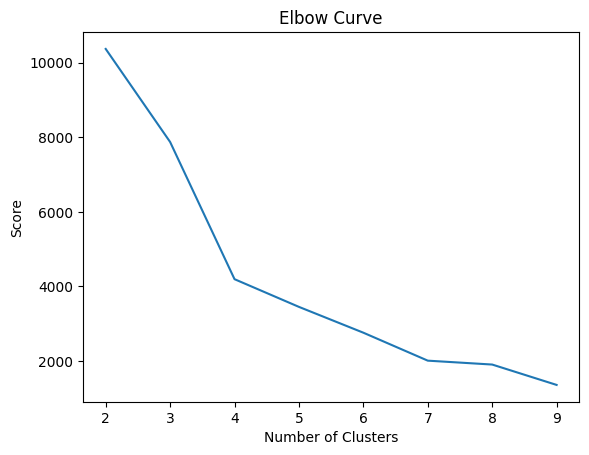

In [86]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

The inflection point(bend of the elbow) seems to be around 4, hence I will choose that as my value of K

In [87]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

### Obtaining predictions from the model

In [88]:
preds = KMeans_fit.transform(data_scale_output)
preds.select(['monetary_value']).show(5,0)

neg_value = preds.filter(col('monetary_value')< 0). count()
neg_value

+------------------+
|monetary_value    |
+------------------+
|153.0             |
|163.3             |
|112.10000000000001|
|185.78000000000003|
|306.84            |
+------------------+
only showing top 5 rows



0

### Analyzing the clusters

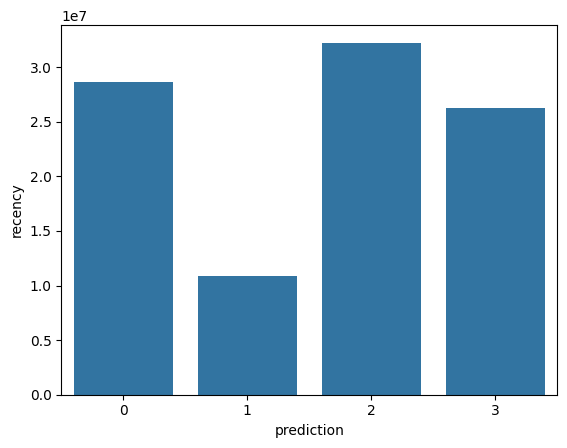

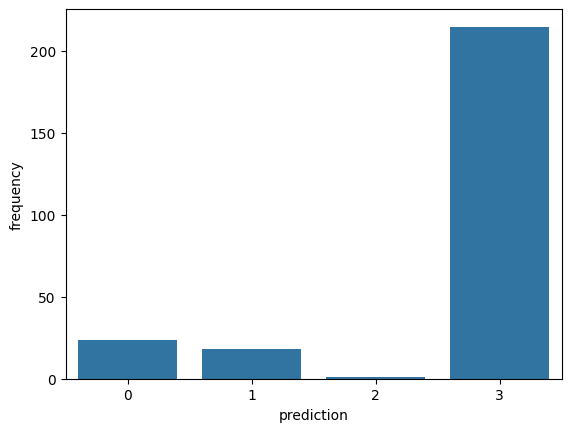

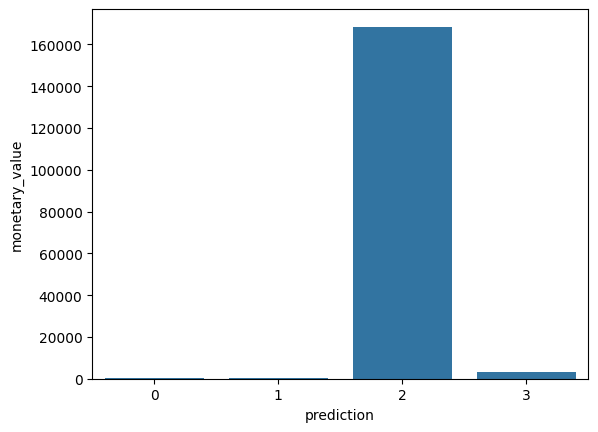

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

CLuster 1 : High recency but low monetary value. So probably buy inexpensive stuff

CLuster 2 : Medium recency, low frequency and monetary values. Have made purchases recently but nothing too significant and not all that frequent either

Cluster 3:High recency and high monetary value. Bought a lot of stuff in the recent times

Cluster 4 : High frequency, high recency. Have been frequenting the app highly off late but yet to make a big money purchase. But slight a promising demographic